# загрузка датасета из гитхаба

In [1]:
!git clone https://github.com/DaryAvelagrom/TrainingData.git

Cloning into 'TrainingData'...
remote: Enumerating objects: 4701, done.
remote: Total 4701 (delta 0), reused 0 (delta 0), pack-reused 4701
Receiving objects: 100% (4701/4701), 169.74 MiB | 12.48 MiB/s, done.
Updating files: 100% (4639/4639), done.


In [2]:
!git clone https://github.com/DaryAvelagrom/TestingData.git

Cloning into 'TestingData'...
remote: Enumerating objects: 2641, done.
remote: Total 2641 (delta 0), reused 0 (delta 0), pack-reused 2641
Receiving objects: 100% (2641/2641), 75.75 MiB | 12.13 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (2584/2584), done.


# загрузка картинок

In [3]:
import os
import numpy as np
from skimage import io


images = []
labels = []

# функция для загрузки картинок по указанному пути
def load_images(data_directory, images, labels):
  
  directories = [dir for dir in os.listdir(data_directory)
                 if os.path.isdir(os.path.join(data_directory,dir))]

  for dir in directories:
    current_directory = os.path.join(data_directory,dir)
    file_names = [os.path.join(current_directory,file) 
                  for file in os.listdir(current_directory)
                  if file.endswith('.ppm')
                 ]
    

    for file in file_names:
      images.append(io.imread(file))
      labels.append(int(dir))

load_images('/content/TrainingData/Training', images, labels)
load_images('/content/TestingData/Testing', images, labels)


images = np.array(images)
labels = np.array(labels)

<ipython-input-3-f7498ca09214>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.array(images)


In [4]:
images.shape, labels.shape

((7095,), (7095,))

# посмотрим на датасет

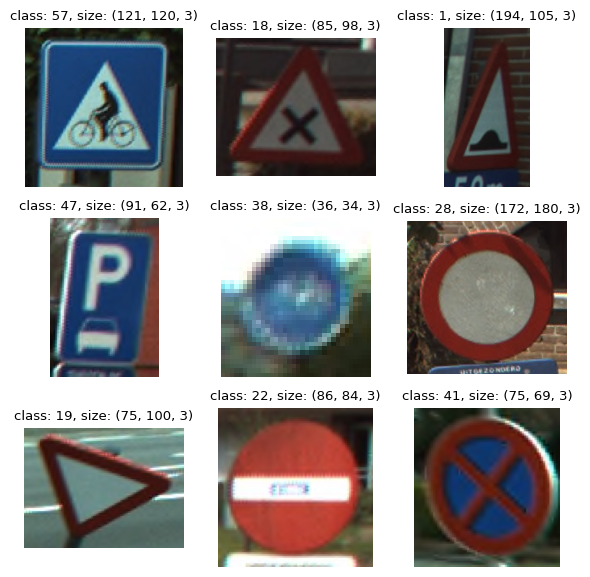

In [5]:
import matplotlib.pyplot as plt

# функция для просмотра 9и случайных картинок
def show_rand_images(images):
  fig, axes = plt.subplots(3, 3, figsize=(7, 7))
  ax = axes.flatten()

  for i in range(9):
    n_im = np.random.randint(0, len(images))
    ax[i].imshow(images[n_im])
    ax[i].set_axis_off()
    ax[i].set_title(f'class: {labels[n_im]}, size: {images[n_im].shape}', fontsize=9.5)

show_rand_images(images)

# подготовка изображений для нейросети

In [6]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# выбор общего размера для всех картинок
для обучения нейросети нам нужны данные одного размера
посмотрим на средний размер изображений

In [7]:
height_and_width = np.array([img.shape[:-1] for img in images])

average_value = np.average(height_and_width, axis=0)

print(f'средние значения высоты: {average_value[0]} и ширины: {average_value[1]}')

средние значения высоты: 118.24059196617335 и ширины: 105.67117688513038


# делаем изображения одного размера 128х128

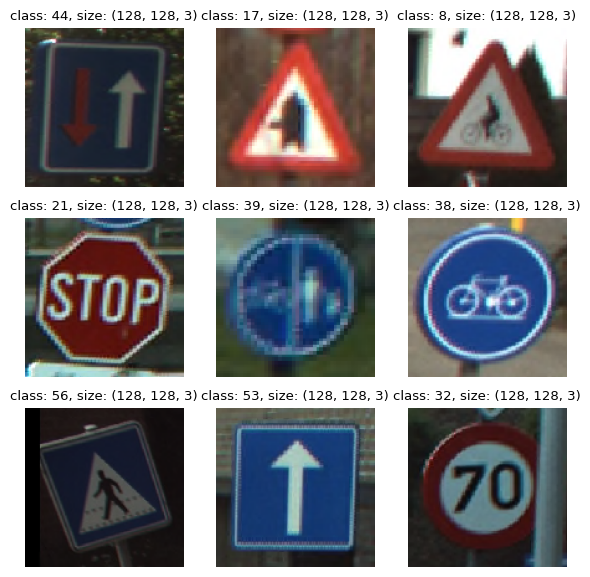

In [8]:
import tensorflow as tf
from keras.utils.image_utils import img_to_array

img_size = [128, 128] 
resized_img = []
for item in images:
  resized = tf.image.resize(item, img_size, method='nearest')
  resized = np.array(resized)
  resized_img.append(resized)


show_rand_images(resized_img)

# разделение датасета на тестовый и тренировачный наборы

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(resized_img, labels, test_size=0.2, random_state=42)

# создание нейронной сети (задаем структуру)

In [10]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import MaxPool2D
from keras.layers import Flatten

In [11]:
model = Sequential() # создаем сеть прямого распространения
model.add(Conv2D(64, (2, 2), activation='relu', input_shape=(128, 128, 3))) # сверточный слой с 64 фильтрами и ядром свертки 2х2 с активацией relu
model.add(MaxPool2D(pool_size=(2, 2), strides = (2,2))) # объединяющий слой (оставляем только максимумы из 4х значений (рассматриваем данные как матрицы 2х2))
model.add(Conv2D(64, (2, 2), activation='relu')) # сверточный слой
model.add(MaxPool2D(pool_size=(2, 2), strides = (2,2))) # снова уменьшаем размерности объединяющим слоем
model.add(Conv2D(32, (2, 2), activation='relu')) # сверточный слой
model.add(MaxPool2D(pool_size=(2, 2), strides = (2,2))) # снова уменьшаем размерности объединяющим слоем
model.add(Conv2D(32, (2, 2), activation='relu')) # сверточный слой
model.add(MaxPool2D(pool_size=(2, 2), strides = (2,2))) # снова уменьшаем размерности объединяющим слоем
model.add(Flatten()) # вытягиваем признаки в вектор
model.add(Dense(512, activation="relu")) # полносвязный слой на 512 нейронов
model.add(Dense(128, activation="relu")) # полносвязный слой на 128 нейронов
model.add(Dense(62, activation="softmax")) # полносвязный слой на 62 нейрона (так как 62 класса) с активацией softmax, которая преобразует значения в вероятность, что данная картинка относится к каждому классу

# Преобразование ответов в формат one_hot_encoding

In [12]:
from keras import utils

y_train = utils.to_categorical(y_train, 62)
y_test = utils.to_categorical(y_test, 62)

# компиляция нейросети

In [13]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]) # Компилируем модель
print(model.summary()) #Вывод структуры модели

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 127, 64)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        16448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        8224      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0

# обучаем нейросеть 

загрузить обученную модель

In [14]:
!git clone https://github.com/DaryAvelagrom/weights.git

Cloning into 'weights'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 0), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), 3.20 MiB | 6.93 MiB/s, done.


In [17]:
model.load_weights('/content/weights/model.h5')

заново обучить модель (~ 52 мин)

In [18]:
#model.fit(np.array(X_train), y_train, batch_size=128, epochs=15, verbose=1)

# сохраняем веса

(уже сохранены)

In [19]:
model.save_weights('/content/weights/model.h5')

# анализ точности нейросети

посмотрим как нейросеть классифицирует 9 случайных картинок из тестового набора данных

1/1 [==============================] - 0s 34ms/step


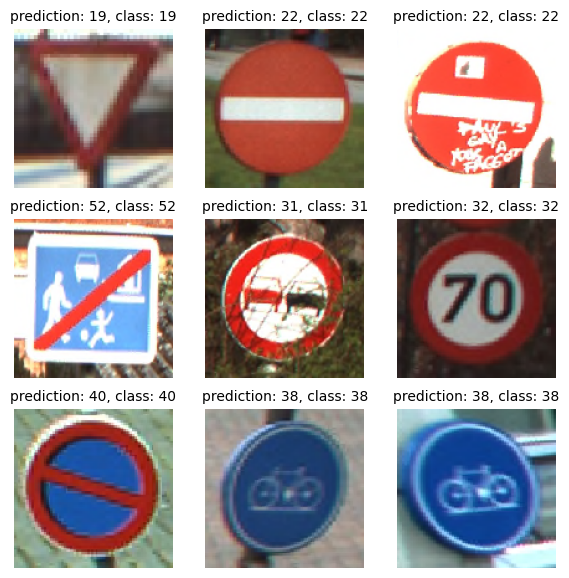

In [20]:
# функция классификации 9и случайных изображений из тестового набора
def predict_rand_img():
    
  fig, axes = plt.subplots(3, 3, figsize=(7, 7))
  ax = axes.flatten()

  for i in range(9):
    n_im = np.random.randint(0, len(X_test))
    img = np.expand_dims(X_test[n_im], axis=0)
    ax[i].imshow(X_test[n_im])
    ax[i].set_axis_off()
    ax[i].set_title(f'prediction: {np.argmax(y_test[n_im])}, class: {np.argmax(model.predict(img))}', fontsize=10)
    
predict_rand_img()


теперь посчитаем процент правильно классифицированных изображений на всем тестовом наборе

In [21]:
count_true = 0

for i, img in enumerate(X_test):
    img = np.expand_dims(img, axis=0)
    prediction = np.argmax(model.predict(img))
    true_class = np.argmax(y_test[i])
    count_true += int(prediction == true_class)
    
print(f'\n\nпроцент распознаных знаков в тестовом наборе: {int(count_true/len(X_test)*100)}%')

1/1 [==============================] - 0s 32ms/step


процент распознаных знаков в тестовом наборе: 96%


нейросеть предсказывает ~ 96% знаков из тестового набора


проверим нейросеть на собственных фотографиях

In [22]:
!git clone https://github.com/DaryAvelagrom/photos.git

Cloning into 'photos'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 11 (delta 2), reused 7 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), 224.17 KiB | 2.80 MiB/s, done.


<ipython-input-23-5721cbf1a78a>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgs = np.array([io.imread(f'/content/photos/photo_{i}.jpg') for i in range(2, 4)])


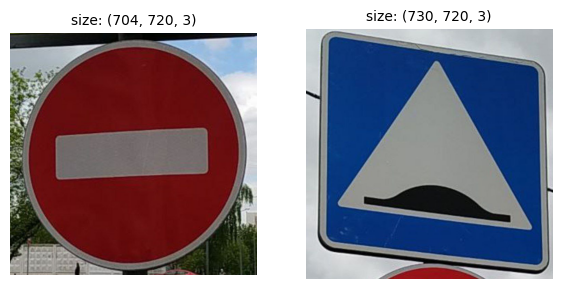

In [23]:
imgs = np.array([io.imread(f'/content/photos/photo_{i}.jpg') for i in range(2, 4)])
imgs_classes = []

fig, axes = plt.subplots(1, 2, figsize=(7, 7))
ax = axes.flatten()

for i in range(2):
  ax[i].imshow(imgs[i])
  ax[i].set_axis_off()
  ax[i].set_title(f'size: {imgs[i].shape}', fontsize=10)

plt.show()

определим, к какому классу относятся фотографии, посморев на примеры знаков из каждого класса

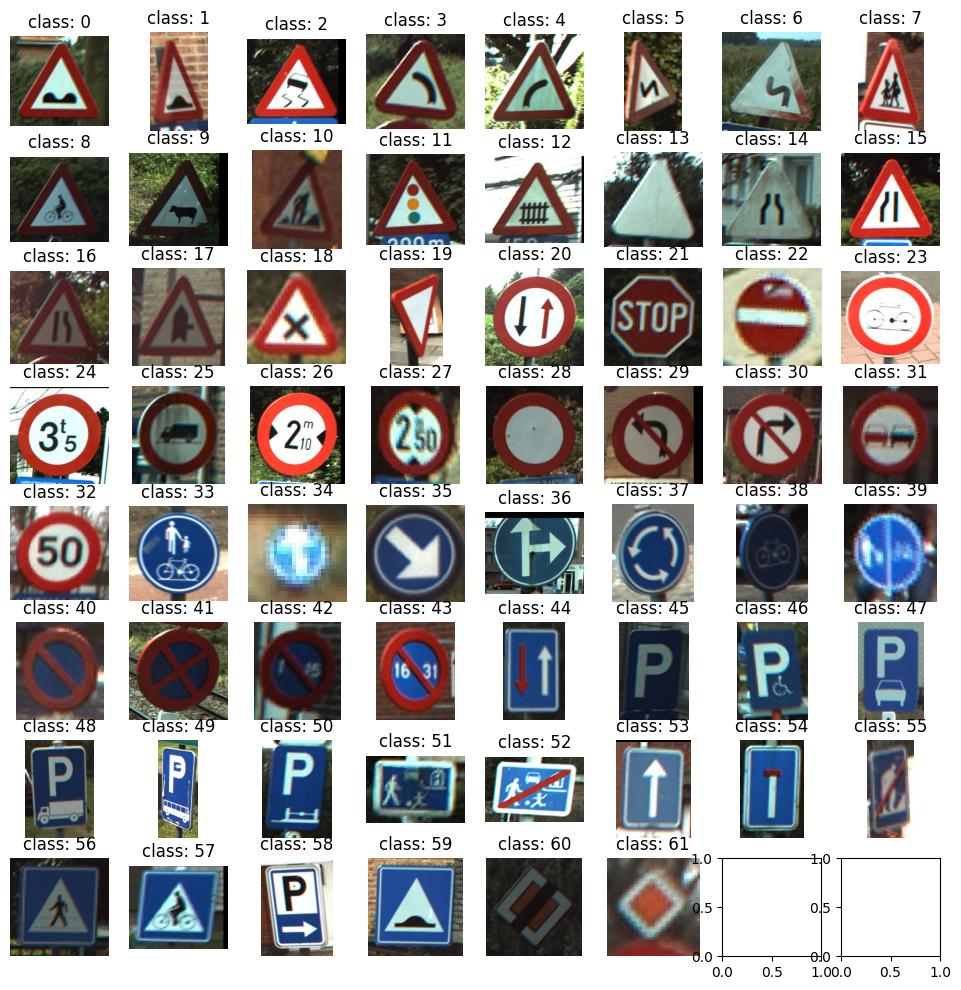

In [24]:
class_example = [list(labels).index(i) for i in range(62)]
class_example

fig, axes = plt.subplots(8, 8, figsize=(12, 12))
ax = axes.flatten()

for i in range(62):
  ax[i].imshow(images[class_example[i]])
  ax[i].set_axis_off()
  ax[i].set_title(f'class: {i}', fontsize=12)

plt.show()

In [25]:
classes = [22, 59]

1/1 [==============================] - 0s 64ms/step


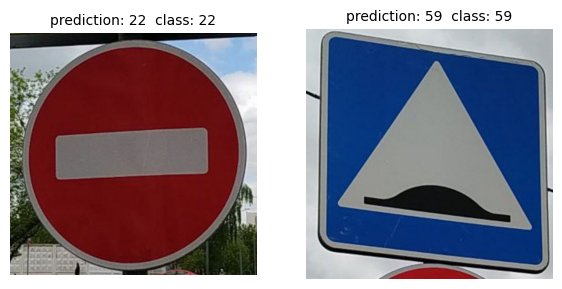

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(7, 7))
ax = axes.flatten()

for i in range(2):
  resized = tf.image.resize(imgs[i], img_size, method='nearest')
  img = np.array(resized)
  img = np.expand_dims(img, axis=0)
  predict = np.argmax(model.predict(img))
  ax[i].imshow(imgs[i])
  ax[i].set_axis_off()
  ax[i].set_title(f'prediction: {predict}  class: {classes[i]}', fontsize=10)

plt.show()